# Reprojecting

In this tutorial, you'll learn how to reproject [Cloud Optimized GeoTIFFs](https://www.cogeo.org/) (COG) into a different [Coordinate Reference System](https://gdal.org/tutorials/osr_api_tut.html) (CRS). 

This tutorial covers several options for reprojecting. Which one to pick depends primarily on two factors: 

* whether you already know what CRS you are targeting when you load your data
* whether your dataset includes [STAC Item](https://github.com/radiantearth/stac-spec/blob/master/item-spec/item-spec.md) information that conforms to the [SpatioTemporal Asset Catalog (STAC)](http://stacspec.org/) specification. 

All remote-sensing datasets in the [Planetary Computer's data catalog](https://planetarycomputer.microsoft.com/catalog) include STAC Item data.

This tutorial covers these four methods for reprojecting geodata:

* [Option 1](Reproject-while-loading-with-stackstac.stack): **Reproject a large number of COGs *while loading*** using [stackstac](https://stackstac.readthedocs.io/en/latest/). This method requires STAC items.
* [Option 2](Reproject-while-loading-with-rioxarray-and-rasterio-using-a-WarpedVRT): **Reproject a single COG *while loading*** with [rioxarray](https://corteva.github.io/rioxarray/stable/) and [rasterio](https://rasterio.readthedocs.io/en/latest/index.html) using a [WarpedVRT](https://rasterio.readthedocs.io/en/latest/topics/virtual-warping.html). This option works without STAC items but won't scale to a large number of COGs.
* [Option 3](Reproject-an-in-memory-array-with-stackstac.reproject_array): **Reproject an *in-memory* (potentially distributed) DataArray** with [`stackstac.reproject_array`](https://stackstac.readthedocs.io/en/latest/api/main/stackstac.reproject_array.html). This option requires more memory and is generally less efficient than option 1, but you don't need to know the destination CRS when loading your data.
* [Option 4](Reproject-an-in-memory-DataArray-with-rioxarray-and-rasterio): **Reproject an *in-memory* (single machine) DataArray** using [rioxarray](https://corteva.github.io/rioxarray/stable/) and [rasterio](https://rasterio.readthedocs.io/en/latest/index.html). This option only works on a single machine and requires more memory than option 2, but you don't need to know the destination CRS when loading your data.

These options are ranked in order of what is generally recommended. However, certain options may not be available for your use case. 

Reprojecting *while loading* the data (options 1 and 2) has a lower memory footprint than reprojecting data that is already in memory. Therefore, if you know what CRS you want to reproject your data into when you load the data, run the reprojection while loading. Also, use `stackstac` to load your data whenever you have suitable STAC Items available.

Note that options 1, 2, and 4 use the [*Geospatial Data Abstraction Library (GDAL)*](https://gdal.org/) internally while option 3 uses `xarray.DataArray.interp` instead.

In [1]:
import planetary_computer as pc
import pystac

import numpy as np
import xarray as xr

import stackstac
import affine
import pyproj
import rioxarray
import rasterio

from rioxarray.rioxarray import _make_coords
from rasterio.vrt import WarpedVRT

import xrspatial.multispectral as ms
import matplotlib.pyplot as plt

## Preparation: Create a local Dask cluster

In this tutorial, you'll be using a small dataset. Create a local Dask cluster to hold your data.

In [2]:
from dask.distributed import Client

client = Client()
print(f"/proxy/{client.scheduler_info()['services']['dashboard']}/status")

/proxy/8787/status


To follow the progress of your computation, you can [access the Dask Dashboard](https://planetarycomputer.microsoft.com/docs/quickstarts/scale-with-dask/#Open-the-dashboard) at the URL from the previous cell's output.

The region of interest for this tutorial is located in Colorado, USA, centered by Cochetopa Dome and Sawtooth Mountain. You'll be using [Sentinel-2 Level-2A](https://planetarycomputer.microsoft.com/dataset/sentinel-2-l2a) data. See [Reading data from the STAC API](https://planetarycomputer.microsoft.com/docs/quickstarts/reading-stac/) for more information on the dataset.

In [3]:
item_id = "S2B_MSIL2A_20190924T175049_N0212_R141_T13SCC_20201004T164728.SAFE"
item = pystac.read_file(
    "https://planetarycomputer.microsoft.com/api/stac/v1/collections/"
    f"sentinel-2-l2a/items/{item_id}"
)
item = pc.sign_assets(item)
item.properties["proj:epsg"]

32613

## Method 1: Reproject while loading with [stackstac.stack](https://stackstac.readthedocs.io/en/latest/api/main/stackstac.stack.html)

The selected scene is stored in an `EPSG:32613` coordinate system. Reproject it to a new CRS by providing the destination `epsg` number to the [stackstac.stack](https://stackstac.readthedocs.io/en/latest/api/main/stackstac.stack.html) function. This function uses [rasterio](https://rasterio.readthedocs.io/en/latest/index.html) internally. 

The data in this example is reprojected to the Lambert Cylindrical projection (`epsg:6933`). [Lambert Cylindrical](https://en.wikipedia.org/wiki/Lambert_cylindrical_equal-area_projection) is an equal-area projection that preserves area measurements. Regions with the same size on the Earth's surface have the same size on the map. However, shapes, angles, and scales are generally distorted.

In [4]:
scene_data = (
    stackstac.stack(
        [item.to_dict()],
        epsg=6933,
        assets=["B04", "B03", "B02"],  # red, green, blue bands
        resolution=100,
        chunksize=2048,
    )
    .isel(time=0)
    .persist()
)

scene_data

<xarray.DataArray 'stackstac-fcd93d6dc3520704b6864ce9535e07d2' (band: 3, y: 995, x: 1235)>
dask.array<getitem, shape=(3, 995, 1235), dtype=float64, chunksize=(1, 995, 1235), chunktype=numpy.ndarray>
Coordinates: (12/46)
    time                                     datetime64[ns] 2019-09-24T17:50:...
    id                                       <U65 'S2B_MSIL2A_20190924T175049...
  * band                                     (band) <U3 'B04' 'B03' 'B02'
  * x                                        (x) float64 -1.035e+07 ... -1.02...
  * y                                        (y) float64 4.591e+06 ... 4.491e+06
    s2:product_type                          <U7 'S2MSI2A'
    ...                                       ...
    gsd                                      int64 10
    proj:bbox                                object {300000.0, 4190220.0, 430...
    common_name                              (band) <U5 'red' 'green' 'blue'
    center_wavelength                        (band) float64 0.665 0.56 0.49
    full_width_half_max                      (band) float64 0.038 0.045 0.098
    epsg                                     int64 6933
Attributes:
    spec:        RasterSpec(epsg=6933, bounds=(-10353400, 4491300, -10229900,...
    crs:         epsg:6933
    transform:   | 100.00, 0.00,-10353400.00|\n| 0.00,-100.00, 4590800.00|\n|...
    resolution:  100

To generate a preview of the reprojected data, create a true color image with the [xrspatil.multispectral.true_color](https://xarray-spatial.org/reference/_autosummary/xrspatial.multispectral.true_color.html) function. 

Provide the following parameters:
* the three bands of `red`, `green`, `blue` in your `scene_data`
* the two optional numeric parameters `c`, `th` for contrast and brightness parameters, respectively
* the optional string value `name` for the image's name

Note: all images in this tutorial will use the same combination of `c` and `th`.

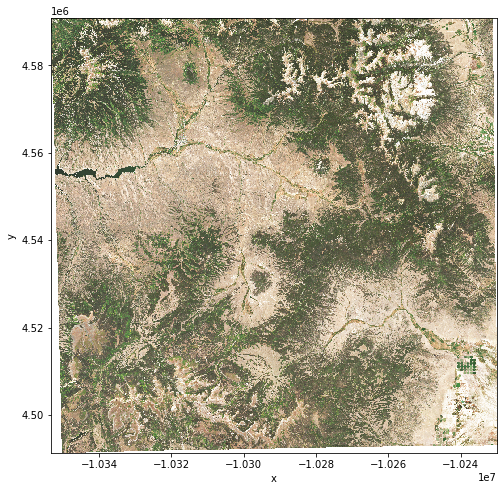

In [5]:
# visualize selected scene
cylindrical_img = ms.true_color(*scene_data, c=30, th=0.05, name="epsg=6933")
cylindrical_img.plot.imshow(figsize=(8, 8));

## Method 2: Reproject while loading with [rioxarray](https://corteva.github.io/rioxarray/stable/) and [rasterio](https://rasterio.readthedocs.io/en/latest/index.html) using a `WarpedVRT`

The following example uses data from the Microsoft Sentinel-2 Azure Blob Storage and reprojects ot from their source CRS of `EPSG:32613` to the Robinson CRS of `ESRI:54030`. This example demonstrates how to normalize a stack of images against a regular grid in a defined bounding box.

With `WarpedVRT`, you only need to provide the geodata's URL as input parameters. You don't need to download any GeoTIFF files beforhand. 

In [6]:
urls = {
    "red": item.assets["B04"].href,
    "green": item.assets["B03"].href,
    "blue": item.assets["B02"].href,
}

The [Robinson projection](https://en.wikipedia.org/wiki/Robinson_projection) is a map projection that does not preserve equal-area nor conformality. As a compromise, both the altitude and longitude lines are evenly spaced across the map.

Follow these steps to reproject your data from `EPSG:32613` to the Robinson CRS of `ESRI:54030`:

**Step 1**: Get the rasterio CRS for `ESRI:54030`.

In [7]:
robinson_crs = pyproj.crs.CRS.from_string("ESRI:54030")
robinson_crs = rasterio.crs.CRS.from_wkt(robinson_crs.to_wkt())
robinson_crs

CRS.from_wkt('PROJCS["World_Robinson",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Robinson"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["ESRI","54030"]]')

Note that in case you want to reproject to an `EPSG` CRS (such as EPSG:4326), you have the option to use only the number (such as 4326) as the destination CRS.

**Step 2**: Define a shape (height, width) and bounding box (coordinates) for the reprojected destination image.

In [ ]:
height = width = 1000
robinson_bounds = (-9438051, 4153437, -9285636, 4046189)

**Step 3**: Calculate a transform to reproject from source CRS to destination CRS.

In [8]:
left, bottom, right, top = robinson_bounds
xres = (right - left) / width
yres = (top - bottom) / height
robinson_transform = affine.Affine(xres, 0.0, left, 0.0, -yres, top)

robinson_transform

Affine(152.415, 0.0, -9438051.0,
       0.0, 107.248, 4046189.0)

**Step 4**: Provide all information to `WarpedVRT` (destination CRS, destination transform, and destination shape).

In [9]:
robinson_vrt_options = {
    "crs": robinson_crs,
    "transform": robinson_transform,
    "height": height,
    "width": width,
}

robinson_reproj = []

for _, url in urls.items():
    with rasterio.open(url) as src:
        with WarpedVRT(src, **robinson_vrt_options) as vrt:
            reproj = rioxarray.open_rasterio(vrt).chunk(
                {"x": 1000, "y": 1000, "band": 1}
            )
            robinson_reproj.append(reproj)

robinson_reproj = xr.concat(robinson_reproj, dim="band")

**Step 5**: Visualize the projection.

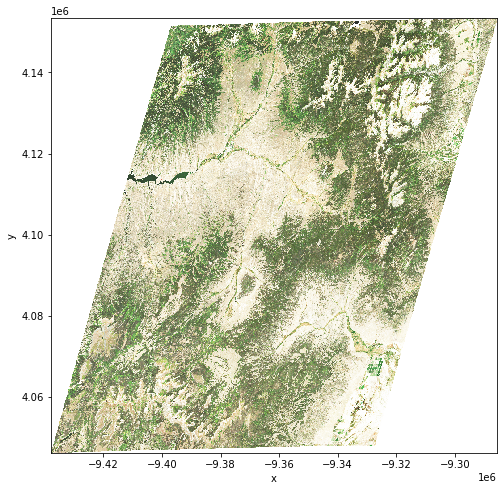

In [11]:
robinson_img = ms.true_color(*robinson_reproj, c=30, th=0.05, name="esri=54030")
robinson_img.plot.imshow(figsize=(8, 8));

## Method 3: Reproject an in-memory array with [stackstac.reproject_array](https://stackstac.readthedocs.io/en/latest/api/main/stackstac.reproject_array.html)

`stackstac` provides a tool called `reproject_array` that uses [scipy.interpolate.interpn](https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interpn.html) internally to reproject and clip a `xarray.DataArray` to a new destination CRS. Therefore, you do not need to have GDAL installed as a dependency for this example. 

This example uses the Space Oblique projection (EPSG: 29873). This projection was explicitly created for satellite imagery and is designed to be free of distortion along the orbit path of a satellite.

`reproject_array` takes a DataArray as its input. Use the scene data you created for the first method described in this notebook as a basis for this section.

In [12]:
space_oblique_crs = 29873
space_oblique_bounds = stackstac.array_bounds(scene_data, space_oblique_crs)

space_oblique_spec = stackstac.raster_spec.RasterSpec(
    epsg=space_oblique_crs, bounds=space_oblique_bounds, resolutions_xy=(100, 100)
)

space_oblique_spec

RasterSpec(epsg=29873, bounds=(10675077.084681889, 9757187.124107027, 10823668.536491105, 9906913.424226366), resolutions_xy=(100, 100))

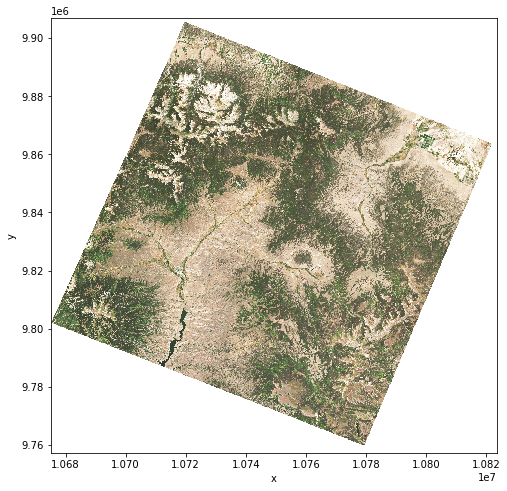

In [13]:
space_oblique_reproj = stackstac.reproject_array(scene_data, space_oblique_spec)

space_oblique_img = ms.true_color(
    *space_oblique_reproj, c=30, th=0.05, name="epsg=29873"
)
space_oblique_img.plot.imshow(figsize=(8, 8));

## Method 4: Reproject an in-memory DataArray with [rioxarray](https://corteva.github.io/rioxarray/stable/) and [rasterio](https://rasterio.readthedocs.io/en/latest/index.html)

[rioxarray](https://corteva.github.io/rioxarray/stable/) and [rasterio](https://rasterio.readthedocs.io/en/latest/index.html) both provide tools for raster warping and reprojection. They both use GDAL under the hood.

#### Reproject in-memory data with rioxarray's `reproject()`

[Web Mercator](https://en.wikipedia.org/wiki/Web_Mercator_projection) is the de facto standard for Web mapping applications and is a variant of the Mercator projection. It is used by many major online map providers. Use [rioxarray's](https://corteva.github.io/rioxarray/stable/) [reproject function](https://corteva.github.io/rioxarray/stable/rioxarray.html#rioxarray.raster_array.RasterArray.reproject) to reproject your data from the CRS of `EPSG:6933` to the Web Mercator CRS of `EPSG:3857`.

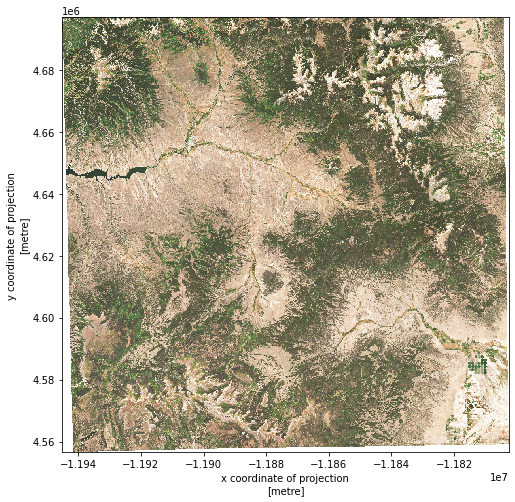

In [14]:
web_mecator_crs = 3857

web_mecator_reproj = scene_data.rio.reproject(web_mecator_crs)
web_mecator_img = ms.true_color(*web_mecator_reproj, c=30, th=0.05, name="epsg=3857")

web_mecator_img.plot.imshow(figsize=(8, 8));

#### Reproject in-memory data with rasterio's `reproject()`
[WGS 84](https://en.wikipedia.org/wiki/World_Geodetic_System) is commonly used in many geodetic applications, including the Global Positioning System (GPS). The WGS 84 projection displays meridians and parallels as equally spaced vertical and horizontal lines. Conversting between x and y coordinates on the map and earth locations is very simple. It is very popular for general use. However, the significant distortions inherent to this method makes it impractical for many scientific applications.


Let's see how our data looks in this crs by reprojecting it with [rasterio.warp.reproject](https://rasterio.readthedocs.io/en/latest/api/rasterio.warp.html#rasterio.warp.reproject) with following steps:

Follow these steps to reproject your data to WGS 84 with [rasterio.warp.reproject](https://rasterio.readthedocs.io/en/latest/api/rasterio.warp.html#rasterio.warp.reproject):

**Step 1**: Get shape, CRS, bounds and transform information from the source dataset and define the destination CRS.

In [15]:
# source information
src_crs = {"init": scene_data.crs}
src_bounds = scene_data.rio.bounds()
src_transform = scene_data.transform
bands, src_height, src_width = scene_data.shape

# destination CRS
WGS84_crs = {"init": "EPSG:4326"}

(Affine(0.0010199914261785408, 0.0, -107.30489322500127,
        0.0, -0.0010199914261785408, 38.827024319904964),
 1255,
 970)

**Step 2**: Calculate the transform and shape of the destination CRS.

In [ ]:
WGS84_transform, WGS84_width, WGS84_height = rasterio.warp.calculate_default_transform(
    src_crs, WGS84_crs, src_width, src_height, *src_bounds
)

# array to write results to
WGS84_data = np.zeros((bands, WGS84_height, WGS84_width))

WGS84_transform, WGS84_width, WGS84_height

**Step 3**: Calculate the coordinates of the destination CRS.

In [16]:
WGS84_coords = _make_coords(
    scene_data, WGS84_transform, WGS84_width, WGS84_height, WGS84_crs
)

WGS84_xs = WGS84_coords["x"]
WGS84_ys = WGS84_coords["y"]

**Step 4**: Reproject the source data to the destination CRS.

In [17]:
rasterio.warp.reproject(
    scene_data,
    WGS84_data,
    src_transform=src_transform,
    src_crs=src_crs,
    dst_transform=WGS84_transform,
    dst_crs=WGS84_crs,
)

**Step 5**: Reconstruct the result as an xarray DataArray.

In [ ]:
WGS84_reproj = xr.DataArray(
    WGS84_data,
    dims=["band", "y", "x"],
    coords={"band": scene_data.band, "y": WGS84_ys, "x": WGS84_xs},
)

**Step 6**: Visualize the projection.

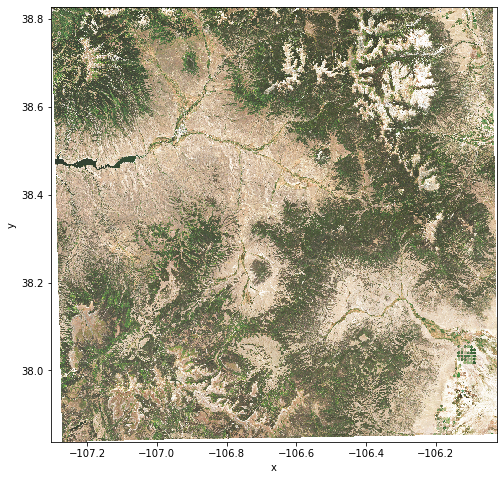

In [18]:
WGS84_img = ms.true_color(*WGS84_reproj, c=30, th=0.05, name="epsg=4326")
WGS84_img.plot.imshow(figsize=(8, 8));

## Wrap-up: Compare different reprojections

To see how reprojecting the same source dataset results in very different visualizations, plot all images side by side.

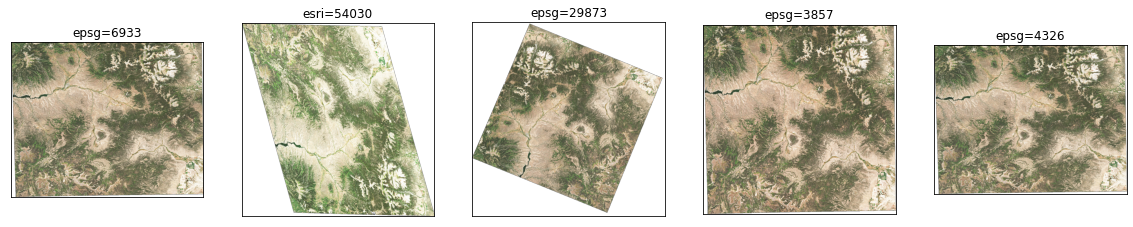

In [19]:
imgs = [cylindrical_img, robinson_img, space_oblique_img, web_mecator_img, WGS84_img]

fig, ax = plt.subplots(nrows=1, ncols=len(imgs), figsize=(20, 15))
for i in range(len(imgs)):
    ax[i].imshow(imgs[i].data)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].set_title(imgs[i].name)

plt.show()